# Serotonin 3D GNN Project


This project builds upon research done by Łapińska et al. (2024): https://doi.org/10.3390/pharmaceutics16030349

Data used: https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_35/

Move the unpacked chembl_35_sqlite.tar.gz file into the data/ dir.

The research linked above presents two Quantitative Structure-Activity Relationship (QSAR) models to predict serotonergic binding affinity and selectivity, respectively, using Mordred molecular 2D descriptors. Specifically, one model classifies compounds binarily as "active" or "inactive", with a cutoff of pKi = 7. Another model does multiclass classification to predict the serotonergic selectivity of compounds previously classified as "active".

I am following a similar approach, but using 3D molecular graph representations instead of 2D molecular descriptors as input modality and using only the ChEMBL database, not ZINC.


## Google Colab Setup


### Configuration


In [9]:
from pathlib import Path

IN_COLAB = False

PATH_NOTEBOOK = (
    Path("/content/drive/MyDrive/Colab Notebooks/serotonin-3d-gnn.ipynb")
    if IN_COLAB
    else Path(
        "/Users/paul/Library/CloudStorage/GoogleDrive-unoutsch@gmail.com/My Drive/Colab Notebooks/serotonin-3d-gnn.ipynb"
    )
)
PATH_REPO = (
    Path("/content/drive/MyDrive/Repositories/serotonin-3d-gnn")
    if IN_COLAB
    else Path.cwd()
)
PATH_DATA = PATH_REPO / "data" / "serotonin_binding_summary.csv"

### Syncing Google Drive with Google Colab Content


In [2]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

### Installing Requirements


In [3]:
%pip install -r "$PATH_REPO/requirements.txt"


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Imports


In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import shutil
import torch
from torch_geometric.data import Data

## Utils


### Syncing this file between Colab and local Git repo


Make sure the paths exist.


In [10]:
if IN_COLAB:
    shutil.copyfile(PATH_NOTEBOOK, PATH_REPO / "serotonin-3d-gnn.ipynb")
else:
    shutil.copyfile(PATH_REPO / "serotonin-3d-gnn.ipynb", PATH_NOTEBOOK)

## Data


### Note on Data Aquisition from chembl_35.db

In order to collect the desired data from the ChEMBL SQL database and transform it into a .csv file, I undertook the steps detailed in `data/README.md`.


### Loading the Data


In [11]:
df = pd.read_csv(PATH_DATA)
df.describe()

,molecule_id,Serotonin (5-HT) receptor,Serotonin 1 (5-HT1) receptor,Serotonin 1 receptors; 5-HT1B & 5-HT1D,Serotonin 1a (5-HT1a) receptor,Serotonin 1b (5-HT1b) receptor,Serotonin 1d (5-HT1d) receptor,Serotonin 1e (5-HT1e) receptor,Serotonin 1f (5-HT1f) receptor,Serotonin 2 (5-HT2) receptor,...,Serotonin 2b (5-HT2b) receptor,Serotonin 2c (5-HT2c) receptor,Serotonin 3 (5-HT3) receptor,Serotonin 3a (5-HT3a) receptor,Serotonin 3b (5-HT3b) receptor,Serotonin 4 (5-HT4) receptor,Serotonin 5a (5-HT5a) receptor,Serotonin 5b (5-HT5b) receptor,Serotonin 6 (5-HT6) receptor,Serotonin 7 (5-HT7) receptor
count,2.345600e+04,90.000000,252.000000,1.0,9462.000000,1492.000000,1472.000000,91.000000,127.000000,1469.000000,...,2337.000000,4343.000000,939.000000,1040.000000,8.000000,1009.000000,422.000000,1.00,4221.000000,3100.000000
mean,1.003325e+06,6.081759,6.683902,6.2,7.258523,6.952528,7.554968,5.791172,7.458423,7.053201,...,6.603829,6.810210,7.625768,7.047520,7.203500,7.645809,6.573801,7.17,7.311171,6.977487
std,8.986583e+05,0.926906,1.104283,NaN,1.152004,1.226482,1.365880,0.652239,0.859240,1.159567,...,0.981462,1.032874,1.225942,1.535413,1.735342,1.179482,1.089819,NaN,1.143388,1.016128
min,9.700000e+01,4.390000,4.100000,6.2,4.000000,4.000000,4.000000,4.800000,5.140000,4.030000,...,4.190000,4.000000,4.010000,4.000000,5.460000,5.000000,4.070000,7.17,4.120000,4.000000
25%,2.291570e+05,5.385000,5.800000,6.2,6.480000,6.050000,6.470000,5.360000,7.000000,6.240000,...,5.900000,6.050000,6.800000,5.700000,5.490000,6.810000,5.800000,7.17,6.470000,6.285000
50%,5.757615e+05,5.925000,6.600000,6.2,7.280000,6.850000,7.640000,5.730000,7.720000,6.920000,...,6.523333,6.740000,7.700000,7.185000,7.015000,7.640000,6.390000,7.17,7.360000,6.990000
75%,1.965967e+06,6.657500,7.585000,6.2,8.060000,7.850000,8.700000,6.175000,8.020000,8.000000,...,7.210000,7.512500,8.580000,8.410000,8.393500,8.400000,7.068750,7.17,8.110000,7.700000
max,2.881244e+06,9.800000,9.300000,6.2,11.000000,10.000000,10.700000,8.200000,8.800000,10.300000,...,10.100000,10.700000,10.420000,10.400000,9.604000,10.800000,9.170000,7.17,10.400000,10.000000


### Analyzing the Data

We can see that the data is relatively sparse: many binding affinity values are unknown. In the following, this sparsity is analyzed.


In [ ]:
# ...

### Appending the 3D Graphical Representations to the Dataframe using RDKit


In [12]:
def generate_3d_image(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Invalid SMILES")
        return None

    mol = Chem.AddHs(mol)

    if AllChem.EmbedMolecule(mol, randomSeed=42) == -1:
        print("3D Embedding Failed")
        return None

    AllChem.UFFOptimizeMolecule(mol)

    img = Draw.MolToImage(mol, size=(300, 300))

    plt.imshow(img)
    plt.axis("off")
    plt.show()

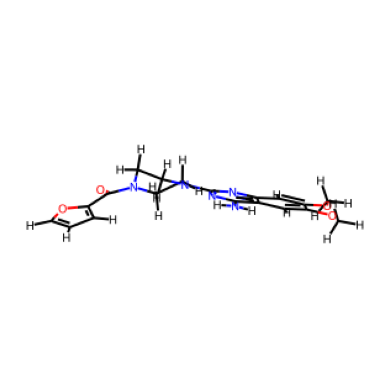

In [13]:
generate_3d_image(df.iloc[0]["canonical_smiles"])

In [14]:
def mol_to_graph(smiles: str) -> Data:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mol = Chem.AddHs(mol)
    if AllChem.EmbedMolecule(mol, randomSeed=42) == -1:
        return None
    AllChem.UFFOptimizeMolecule(mol)
    conformer = mol.GetConformer()

    atom_features, positions = [], []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
        ]
        atom_features.append(features)
        pos = conformer.GetAtomPosition(atom.GetIdx())
        positions.append([pos.x, pos.y, pos.z])
    x = torch.tensor(atom_features, dtype=torch.float)
    pos = torch.tensor(positions, dtype=torch.float)

    edge_index, edge_attr = [], []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond_feat = [bond.GetBondTypeAsDouble(), 1.0 if bond.GetIsConjugated() else 0.0]
        # add both directions for an undirected graph
        edge_index += [[i, j], [j, i]]
        edge_attr += [bond_feat, bond_feat]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr)

Data(x=[21, 4], edge_index=[2, 42], edge_attr=[42, 2], pos=[21, 3])


In [17]:
graph_data = mol_to_graph(df.iloc[100]["canonical_smiles"])
print(graph_data)

print("Node features (x):")
print(graph_data.x)

print("\n3D positions (pos):")
print(graph_data.pos)

print("\nEdge index (connectivity):")
print(graph_data.edge_index)

print("\nEdge attributes:")
print(graph_data.edge_attr)
"""
explanation of output:
- x is the node feature matrix, where each row represents an atom and the columns represent its features
- here, each atom is described by its atomic number, degree, formal charge, and an integer encoding its hybridization
- this tensor will be the input to the GNN
"""

Data(x=[51, 4], edge_index=[2, 110], edge_attr=[110, 2], pos=[51, 3])


In [ ]:
df["3d_mol"] = df["canonical_smiles"].apply(mol_to_graph)
df.iloc[0]["3d_mol"]

[16:12:12] UFFTYPER: Unrecognized charge state for atom: 1
[16:12:12] UFFTYPER: Unrecognized charge state for atom: 1
[16:12:22] UFFTYPER: Unrecognized charge state for atom: 14
[16:12:22] UFFTYPER: Unrecognized charge state for atom: 14
[16:13:02] UFFTYPER: Unrecognized charge state for atom: 12
[16:13:02] UFFTYPER: Unrecognized charge state for atom: 12
[16:15:18] UFFTYPER: Unrecognized charge state for atom: 21
[16:15:18] UFFTYPER: Unrecognized charge state for atom: 21
[16:16:34] UFFTYPER: Unrecognized charge state for atom: 12
[16:16:34] UFFTYPER: Unrecognized charge state for atom: 12
[16:16:45] UFFTYPER: Unrecognized charge state for atom: 1
[16:16:45] UFFTYPER: Unrecognized charge state for atom: 1
[16:16:51] UFFTYPER: Warning: hybridization set to SP3 for atom 29
[16:16:51] UFFTYPER: Warning: hybridization set to SP3 for atom 29
[16:16:51] UFFTYPER: Warning: hybridization set to SP3 for atom 29
[16:16:53] UFFTYPER: Warning: hybridization set to SP3 for atom 27
[16:16:53] UFFTY

In [ ]:
df.to_pickle("serotonin_binding_df_3d_mol.pkl")

In [ ]:
pickle_file = "serotonin_binding_df_3d_mol.pkl"
if os.path.exists(pickle_file):
    df = pd.read_pickle(pickle_file)
    print("DataFrame loaded from pickle!")
else:
    print("Pickle file not found. Please generate the DataFrame and save it first.")

### Transforming the Data into a NumPy Array


In [ ]:
data_numpy = (
    df.astype(object).where(pd.notna(df), None).to_numpy()
)  # create a numpy array in which nan is replaced with None
len(data_numpy), data_numpy[0]

(23456,
 array([97, 'COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC', None, None,
        None, 5.44333333333333, None, 9.48, None, None, 4.38, None, 5.82,
        5.2825, None, None, None, None, None, None, None, None, None],
       dtype=object))